<a href="https://colab.research.google.com/github/amd-rezaei/colab_gists/blob/main/networks_onnx_checkoutputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf /content/Network_validation.zip
!rm -rf /content/Network_validation

In [ ]:
!unzip /content/Network_validation.zip -d /content

Archive:  /content/Network_validation.zip
   creating: /content/Network_validation/
  inflating: /content/Network_validation/FC_2Layer_INT8_input.npy  
  inflating: /content/Network_validation/FC_2Layer_INT8_output.npy  
   creating: /content/Network_validation/float_model/
  inflating: /content/Network_validation/float_model/Add_0_param0.npy  
  inflating: /content/Network_validation/float_model/Add_1_param0.npy  
  inflating: /content/Network_validation/float_model/MatMul_0_param0.npy  
  inflating: /content/Network_validation/float_model/MatMul_1_param0.npy  
  inflating: /content/Network_validation/float_model/Mul_1_param0.npy  
   creating: /content/Network_validation/int_model/
  inflating: /content/Network_validation/int_model/Add_0_param0.npy  
  inflating: /content/Network_validation/int_model/Add_1_param0.npy  
  inflating: /content/Network_validation/int_model/MatMul_0_param0.npy  
  inflating: /content/Network_validation/int_model/MatMul_1_param0.npy  
  inflating: /content

In [ ]:
import numpy as np

class NeuralNetworkLayer:
    def __init__(self, input_data, weights=None):
        """
        Initialize the layer with input data and optional weights.
        """
        self.input_data = input_data
        self.weights = weights

    def perform_matrix_multiplication(self):
        """
        Perform matrix multiplication between input data and weights.
        """
        if self.weights is None:
            raise ValueError("Weights must be set for matrix multiplication.")
        return np.dot(self.input_data, self.weights)

    @staticmethod
    def apply_binary_shift(data, shift_values):
        """
        Apply a binary shift operation to the data based on shift values.
        """
        output = np.copy(data)
        for i in range(data.shape[0]):
            shift_amount = shift_values[i]
            if shift_amount < 0:
                output[i] *= (2 ** abs(shift_amount))
            else:
                output[i] /=  (2 ** (shift_amount))
        return output

    @staticmethod
    def apply_binary_shift_single(data, shift_amount):
        """
        Apply a single binary shift operation to the data.
        """
        if shift_amount > 0:
            return data / (2 ** abs(shift_amount))
        else:
            return data * (2 ** (shift_amount))

    @staticmethod
    def perform_addition(data, biases):
        """
        Add biases to the data element-wise.
        """
        if biases is None:
            raise ValueError("Biases must be provided for addition.")
        return data + biases

    @staticmethod
    def apply_relu(data):
        """
        Apply ReLU activation function to the data.
        """
        return np.maximum(0, data)

    @staticmethod
    def apply_clip(data, min_value, max_value):
        """
        Clip the data to a specified range.
        """
        return np.clip(data, min_value, max_value)

def load_and_prepare_input(input_path, scale_factor):
    """
    Load input data and scale it appropriately.
    """
    input_data = (np.load(input_path)[1] * scale_factor).flatten().astype(np.float32)
    return np.clip(input_data, -128, 127)

def int_model_pipeline():
    """
    Execute the integer-based neural network pipeline.
    """
    # Load and prepare input data
    input_arr = load_and_prepare_input("Network_validation/FC_2Layer_INT8_input.npy", 64)

    # Load weights and biases
    weights_matmul0 = np.load("Network_validation/int_model/MatMul_0_param0.npy").astype(np.int16)  # (784, 128)
    weights_mul1 = np.load("Network_validation/int_model/Mul_1_param0.npy").astype(np.int16) * -1  # (128,)
    weights_add0 = np.load("Network_validation/int_model/Add_0_param0.npy").astype(np.int16)  # (128,)
    weights_matmul1 = np.load("Network_validation/int_model/MatMul_1_param0.npy").astype(np.int16)  # (128, 10)
    weights_add1 = np.load("Network_validation/int_model/Add_1_param0.npy").astype(np.int16)  # (10,)
    # print(input_arr)
    # Layer 1: Matrix Multiplication
    layer1 = NeuralNetworkLayer(input_data=input_arr, weights=weights_matmul0)
    matmul0_out = layer1.perform_matrix_multiplication()

    # print(matmul0_out)
    # Layer 2: Binary Shift
    matmul0_shifted = layer1.apply_binary_shift(matmul0_out, -1 * weights_mul1.flatten())

    print(matmul0_shifted)

    # Layer 3: Addition
    matmul0_added = layer1.perform_addition(matmul0_shifted, weights_add0.flatten())
    # print(matmul0_added)
    # Layer 4: ReLU Activation -> Binary Shift -> Clip
    relu_out = layer1.apply_relu(matmul0_added).astype(np.int32)

    relu_out_shifted = layer1.apply_binary_shift_single(relu_out, shift_amount=5)
    # print(relu_out_shifted)
    relu_out_clipped = layer1.apply_clip(relu_out_shifted, min_value=-128, max_value=127)

    # Layer 5: Second Matrix Multiplication
    layer2 = NeuralNetworkLayer(input_data=relu_out_clipped, weights=weights_matmul1)
    matmul1_out = layer2.perform_matrix_multiplication()
    print(matmul1_out)

    # Layer 6: Binary Shift -> Addition
    matmul1_shifted = layer2.apply_binary_shift_single(matmul1_out, shift_amount=4)
    final_output = layer2.perform_addition(matmul1_shifted, weights_add1.flatten())

    # Display the result
    print("Final Output:", final_output)
    output_orig = np.load("Network_validation/FC_2Layer_INT8_output.npy").astype(np.int16)  # (10,)
    print("Original Output:", output_orig[1])

if __name__ == "__main__":
    int_model_pipeline()


[  -197.48291   9128.5625   15406.67     17210.79      2624.4172
   9957.561    10653.352    -2334.3076   -8463.016     2894.167
  -2645.4673    3762.9248   -8074.0664    4243.711     3866.3838
    461.042   -14597.919     2962.8062   -3782.6045   18082.84
    856.25    -13658.333   -10482.681    10915.966     5249.1826
   5619.609    -4354.5073    6637.691   -15677.4375    6007.582
  13700.673     8384.824     8244.4      -6045.967    -3780.625
  -7975.2266    9508.367     9805.11    -14070.312    -2932.731
  -1219.0583   10237.684    -1502.1279   -4024.7021   -1273.9666
  -2612.038    14004.06      2681.2207   -8708.01     13563.488
   8749.413    -7540.373    22308.12    -29942.727     7844.0977
  -6888.956     1454.6105  -19925.543    15658.814     4812.8564
 -16056.998   -22459.408     1745.2793   17366.518    -3253.2163
  19661.781    -3983.775      682.4873   12784.209     7586.838
   1015.63184   6531.812    16845.834     2993.8828   -4279.2173
 -12253.921    12098.104    12632

In [ ]:
np.load("Network_validation/int_model/Mul_1_param0.npy").astype(np.int16) * -1  # (128,)

array([[-17, -17, -17, -17, -17, -17, -17, -17, -18, -17, -17, -17, -18,
        -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17,
        -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17,
        -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17,
        -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17,
        -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17,
        -17, -17, -17, -17, -17, -18, -17, -17, -17, -17, -17, -18, -17,
        -18, -17, -17, -17, -17, -17, -17, -17, -17, -18, -17, -17, -17,
        -17, -17, -17, -17, -18, -17, -17, -18, -17, -17, -18, -17, -17,
        -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17]],
      dtype=int16)

In [ ]:
matmul1_added

array([ -6958,  -9551, -19771, -19362,   5473, -13283, -15265, -17956,
        -4185,  -8777])

In [ ]:
import numpy as np

class NeuralNetworkLayer:
    def __init__(self, input_data, weights=None, biases=None):
        """
        Initialize the layer with input data, weights, and optional biases.
        """
        self.input_data = input_data
        self.weights = weights
        self.biases = biases

    def perform_matrix_multiplication(self):
        """
        Perform matrix multiplication between input data and weights.
        """
        if self.weights is None:
            raise ValueError("Weights must be set for matrix multiplication.")
        return np.dot(self.input_data, self.weights)

    @staticmethod
    def apply_multiplication(data, scalar):
        """
        Apply scalar multiplication to the data.
        """
        return data * scalar

    @staticmethod
    def perform_addition(data, biases):
        """
        Add biases to the data element-wise.
        """
        if biases is None:
            raise ValueError("Biases must be provided for addition.")
        return data + biases

    @staticmethod
    def apply_relu(data):
        """
        Apply ReLU activation function to the data.
        """
        return np.maximum(0, data)

    @staticmethod
    def apply_clip(data, min_value, max_value):
        """
        Clip the data to a specified range.
        """
        return np.clip(data, min_value, max_value)

def load_and_prepare_input(input_path):
    """
    Load input data, ensure it's reshaped to (28, 28, 1), and flatten it.
    """
    input_data = np.load(input_path)[1]  # Assuming input shape is correct
    if input_data.shape != (28, 28, 1):  # Ensure correct input shape
        raise ValueError(f"Expected input shape (28, 28, 1), but got {input_data.shape}")
    return input_data.flatten().astype(np.float32)  # Flatten to (784,)

def neural_network_pipeline():
    """
    Execute the neural network pipeline as per the provided architecture.
    """
    # Load and prepare input data
    input_arr = load_and_prepare_input("Network_validation/FC_2Layer_INT8_input.npy")  # Replace with your file path

    # Load weights and biases
    weights_matmul0 = np.load("Network_validation/float_model/MatMul_0_param0.npy").astype(np.float32)  # (784, 128)
    weights_matmul1 = np.load("Network_validation/float_model/MatMul_1_param0.npy").astype(np.float32)  # (128, 10)
    biases_add0 = np.load("Network_validation/float_model/Add_0_param0.npy").astype(np.float32)  # (128,)
    biases_add1 = np.load("Network_validation/float_model/Add_1_param0.npy").astype(np.float32)  # (10,)


    # Define scalar values
    scalar_mul1 = 0.017720628833
    arrary_mul1 = np.load("Network_validation/float_model/Mul_1_param0.npy").astype(np.float32)
    scalar_mul2 = 0.0383226
    scalar_mul3 = 0.09033888
    # print(input_arr)
    # Layer 1: Flatten -> Multiply -> Clip
    input_arr = NeuralNetworkLayer.apply_multiplication(input_arr, scalar_mul1)
    # print(input_arr)
    input_arr = NeuralNetworkLayer.apply_clip(input_arr, -128, 127)

    # Layer 2: Matrix Multiplication -> Multiply -> Add
    layer1 = NeuralNetworkLayer(input_data=input_arr, weights=weights_matmul0)
    matmul0_out = layer1.perform_matrix_multiplication()




    matmul0_out = NeuralNetworkLayer.apply_multiplication(matmul0_out, arrary_mul1 )

    matmul0_out = NeuralNetworkLayer.perform_addition(matmul0_out, biases_add0)
    # print(matmul0_out)
    # Layer 3: ReLU -> Multiply -> Clip
    relu_out = NeuralNetworkLayer.apply_relu(matmul0_out)

    relu_out = NeuralNetworkLayer.apply_multiplication(relu_out, scalar_mul2)
    # print(relu_out)
    relu_out = NeuralNetworkLayer.apply_clip(relu_out, -128, 127)

    # Layer 4: Matrix Multiplication -> Multiply -> Add
    layer2 = NeuralNetworkLayer(input_data=relu_out, weights=weights_matmul1)
    matmul1_out = layer2.perform_matrix_multiplication()
    print(matmul1_out)
    matmul1_out = NeuralNetworkLayer.apply_multiplication(matmul1_out, scalar_mul3)
    final_output = NeuralNetworkLayer.perform_addition(matmul1_out, biases_add1)

    # Display the result
    print("Final Output:", final_output)
    output_orig = np.load("Network_validation/FC_2Layer_INT8_output.npy").astype(np.float32)  # (10,)
    print("Original Output:", output_orig[1])


if __name__ == "__main__":
    neural_network_pipeline()


[[ -29.454048     2.0801315   78.17094    -26.209227  -101.2166
   -86.01786    -52.060074   -49.134064     9.474168  -100.01539  ]]
Final Output: [[-2.7187862  0.1174126  7.01244   -2.3335845 -9.164965  -7.7568307
  -4.642387  -4.5461736  0.8845214 -9.0340605]]
Original Output: [-2.6028504  -0.37198994  6.6259556  -1.1489278  -9.00459    -6.1865926
 -4.0034914  -3.6587152   0.46892825 -8.102231  ]


In [ ]:
!rm -rf /content/float_model
!rm -rf /content/int_model
!rm -rf /content/FC_2Layer_INT8_input.npy
!rm -rf /content/FC_2Layer_INT8_output.npy

full int

In [ ]:
import numpy as np

class NeuralNetworkLayer:
    def __init__(self, input_data, weights=None, biases=None):
        """
        Initialize the layer with input data, weights, and optional biases.
        """
        self.input_data = input_data
        self.weights = weights
        self.biases = biases

    def perform_matrix_multiplication(self):
        """
        Perform matrix multiplication between input data and weights.
        """
        if self.weights is None:
            raise ValueError("Weights must be set for matrix multiplication.")
        return np.dot(self.input_data, self.weights)

    @staticmethod
    def apply_multiplication(data, scalar):
        """
        Apply scalar multiplication to the data.
        """
        return data * scalar

    @staticmethod
    def perform_addition(data, biases):
        """
        Add biases to the data element-wise.
        """
        if biases is None:
            raise ValueError("Biases must be provided for addition.")
        return data + biases

    @staticmethod
    def apply_relu(data):
        """
        Apply ReLU activation function to the data.
        """
        return np.maximum(0, data)

    @staticmethod
    def apply_clip(data, min_value, max_value):
        """
        Clip the data to a specified range.
        """
        return np.clip(data, min_value, max_value)

def load_and_prepare_input(input_path):
    """
    Load input data, ensure it's reshaped to (28, 28, 1), and flatten it.
    """
    input_data = np.load(input_path)[0]  # Assuming input shape is correct
    if input_data.shape != (28, 28, 1):  # Ensure correct input shape
        raise ValueError(f"Expected input shape (28, 28, 1), but got {input_data.shape}")
    return input_data.flatten().astype(np.int32)  # Flatten to (784,)

def neural_network_pipeline():
    """
    Execute the neural network pipeline using integer operations.
    """
    # Load and prepare input data
    input_arr = load_and_prepare_input("FC_2Layer_INT8_input.npy")  # Input as integers

    # Load weights and biases
    scalar_mul1 = 0.0164484  # First layer scalar multiplier
    weights_matmul0 = np.load("float_model/MatMul_0_param0.npy").astype(np.float32)  # (784, 128)
    biases_add0 = np.load("float_model/Add_0_param0.npy").astype(np.float32)  # (128,)
    array_mul1 = np.load("float_model/Mul_1_param0.npy").astype(np.float32)  # Multiplier array (128,)
    scalar_mul2 = 0.0383226
    scalar_mul3 = 0.09033888
    weights_matmul1 = np.load("float_model/MatMul_1_param0.npy").astype(np.float32)  # (128, 10)
    biases_add1 = np.load("float_model/Add_1_param0.npy").astype(np.float32)  # (10,)

    # Incorporate scalar_mul1 into weights and biases of the first layer
    weights_matmul0_scaled = np.round(weights_matmul0 * scalar_mul1).astype(np.float32)
    biases_add0_scaled = np.round(biases_add0 * scalar_mul1).astype(np.float32)
    print(weights_matmul0_scaled)
    # Layer 1: Flatten -> Clip -> MatMul -> Add
    input_clipped = NeuralNetworkLayer.apply_clip(input_arr, -128, 127)  # Clip input to [-128, 127]
    layer1 = NeuralNetworkLayer(input_data=input_clipped, weights=weights_matmul0_scaled, biases=biases_add0_scaled)
    matmul0_out = layer1.perform_matrix_multiplication()
    matmul0_out = NeuralNetworkLayer.perform_addition(matmul0_out, biases_add0_scaled)

    # Layer 2: ReLU -> Multiply -> Clip
    relu_out = NeuralNetworkLayer.apply_relu(matmul0_out)
    relu_out_scaled = NeuralNetworkLayer.apply_multiplication(relu_out, scalar_mul2)
    relu_out_clipped = NeuralNetworkLayer.apply_clip(relu_out_scaled, -128, 127)

    # Layer 3: MatMul -> Multiply -> Add
    weights_matmul1_scaled = np.round(weights_matmul1 * scalar_mul2).astype(np.float32)
    biases_add1_scaled = np.round(biases_add1 * scalar_mul2).astype(np.float32)

    layer2 = NeuralNetworkLayer(input_data=relu_out_clipped, weights=weights_matmul1_scaled, biases=biases_add1_scaled)
    matmul1_out = layer2.perform_matrix_multiplication()
    matmul1_out_scaled = NeuralNetworkLayer.apply_multiplication(matmul1_out, scalar_mul3)
    final_output = NeuralNetworkLayer.perform_addition(matmul1_out_scaled, biases_add1_scaled)

    # Display the result
    print("Final Output:", final_output)
    output_orig = np.load("FC_2Layer_INT8_output.npy").astype(np.float32)  # (10,)
    print("Original Output:", output_orig[0])

if __name__ == "__main__":
    neural_network_pipeline()


FileNotFoundError: [Errno 2] No such file or directory: 'FC_2Layer_INT8_input.npy'

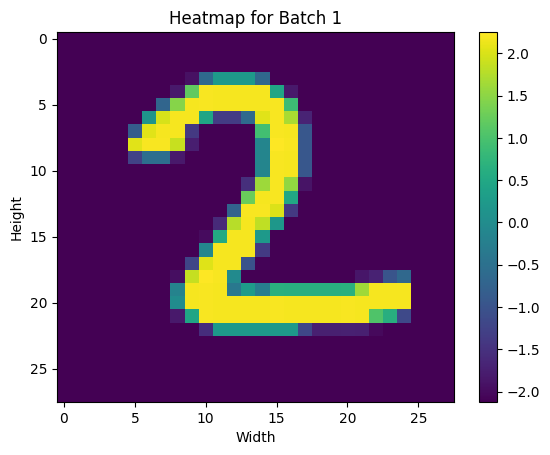

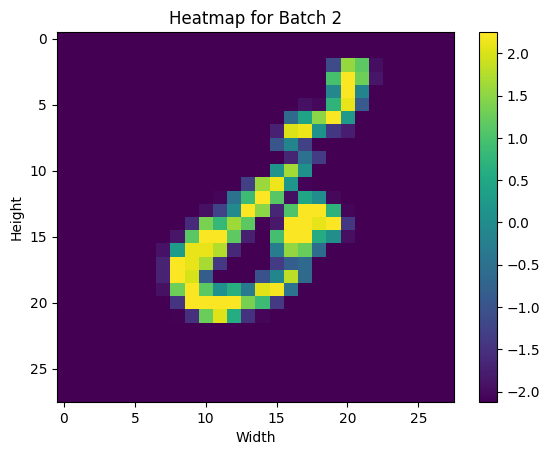

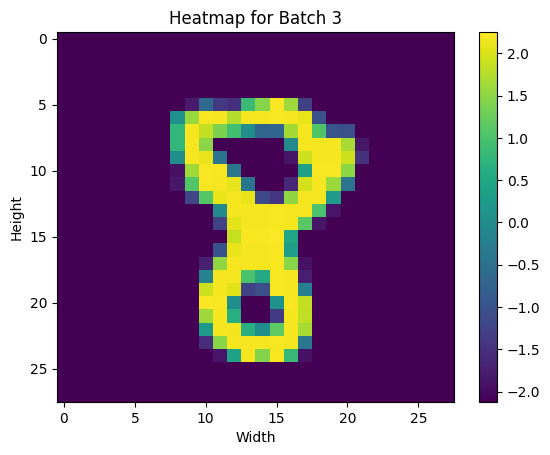

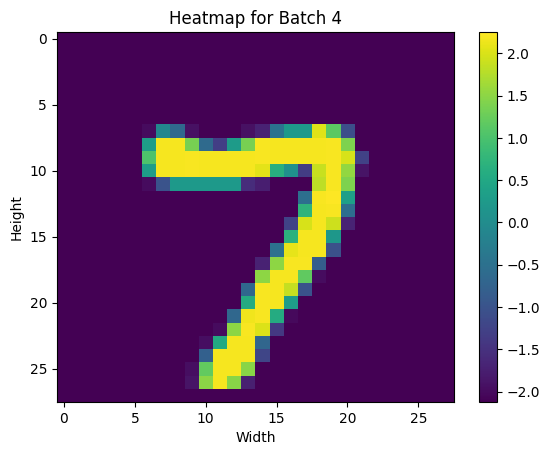

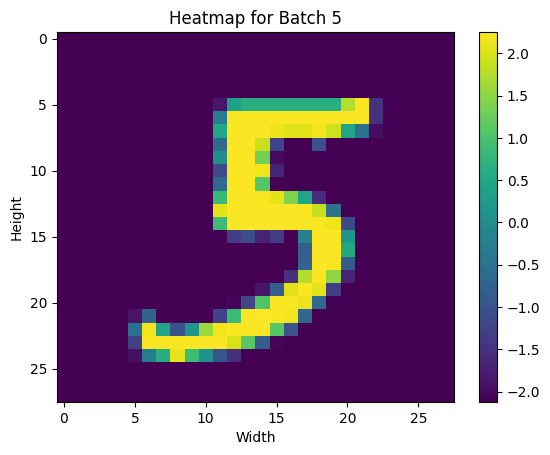

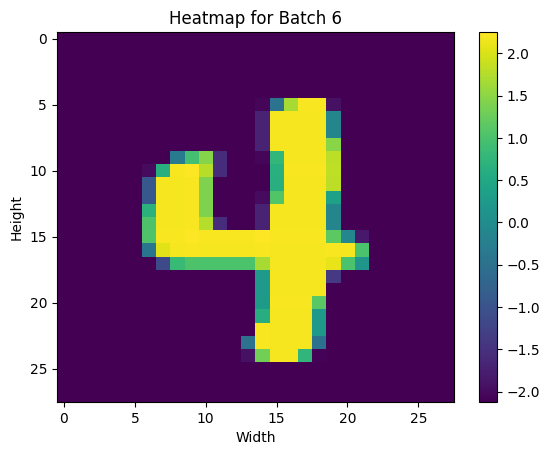

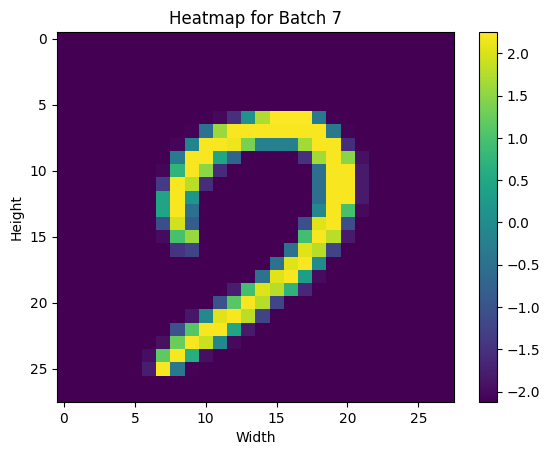

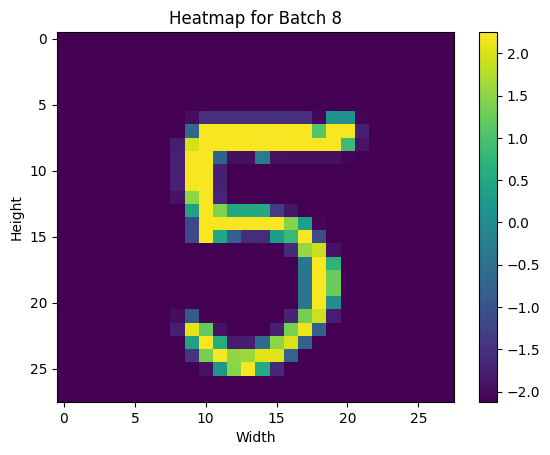

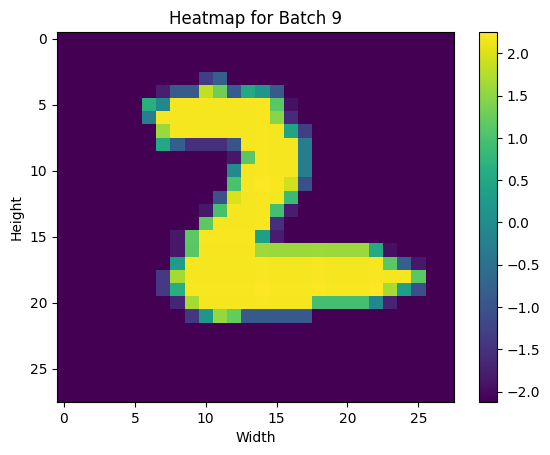

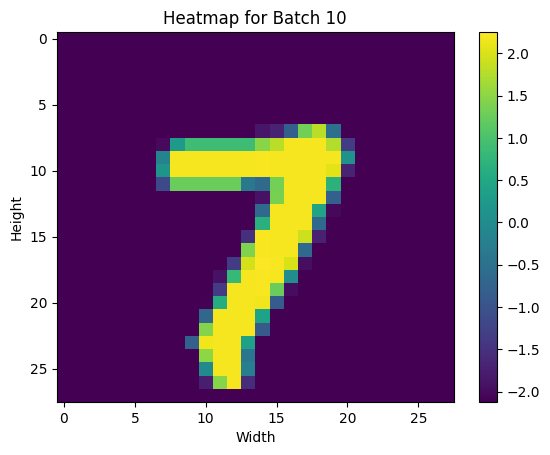

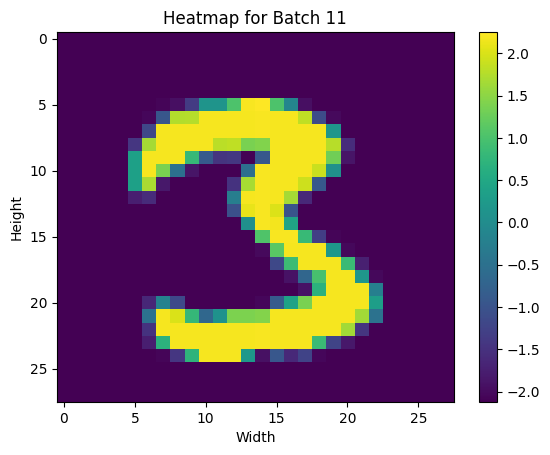

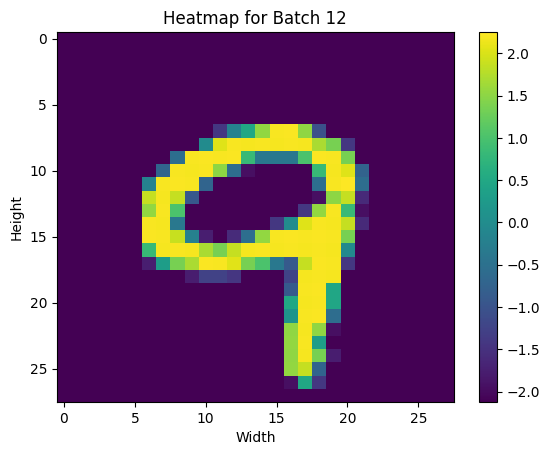

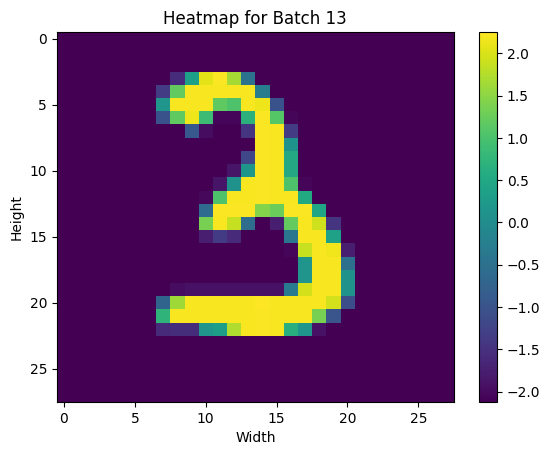

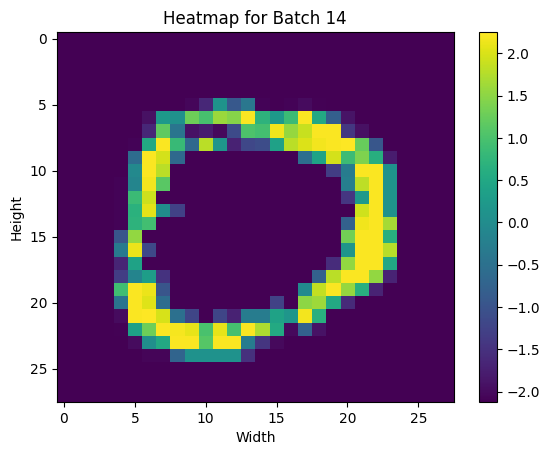

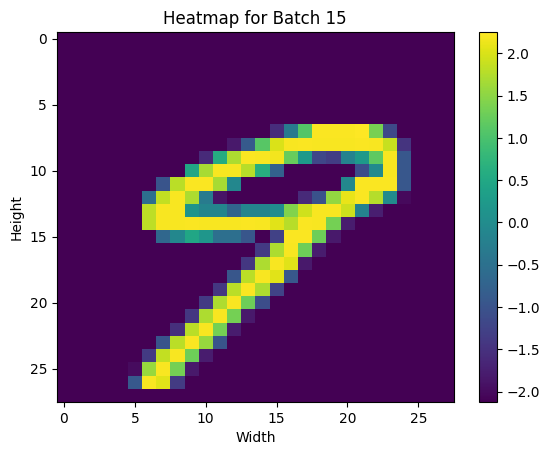

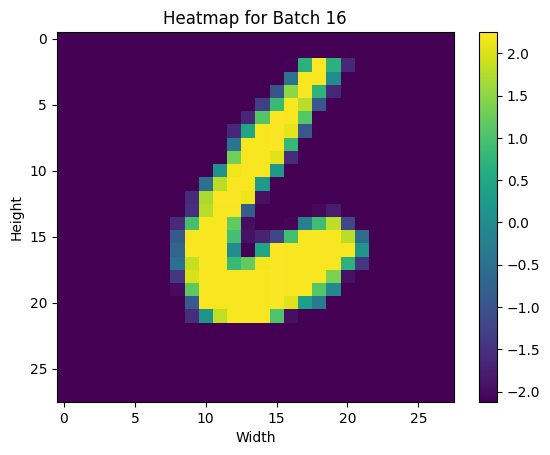

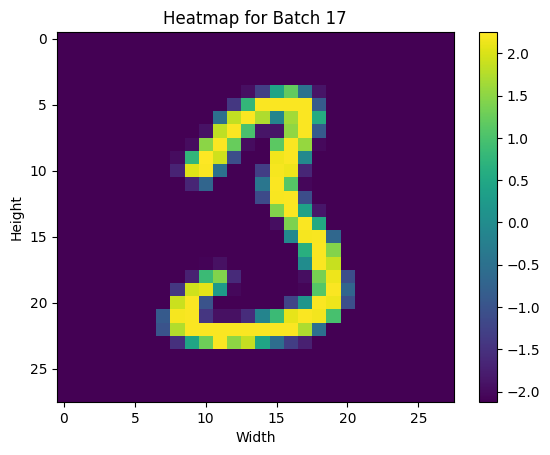

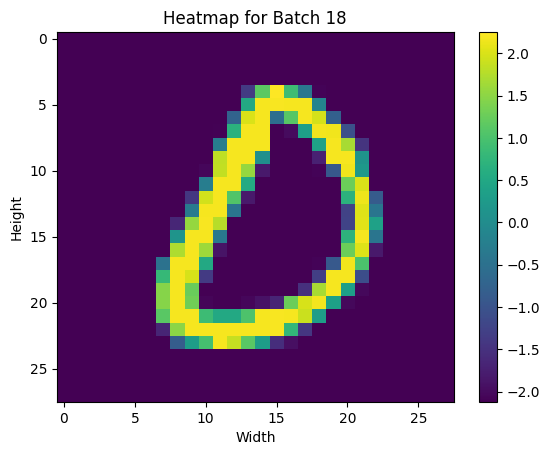

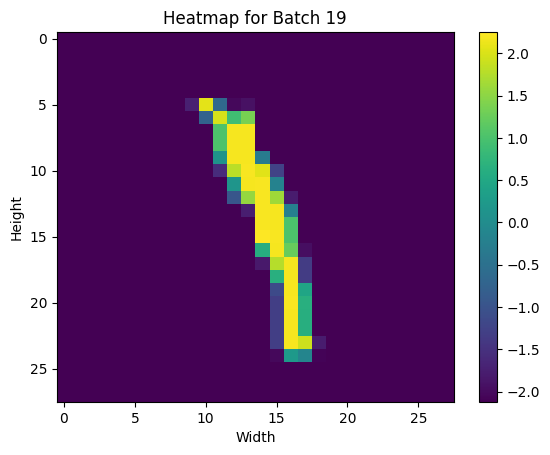

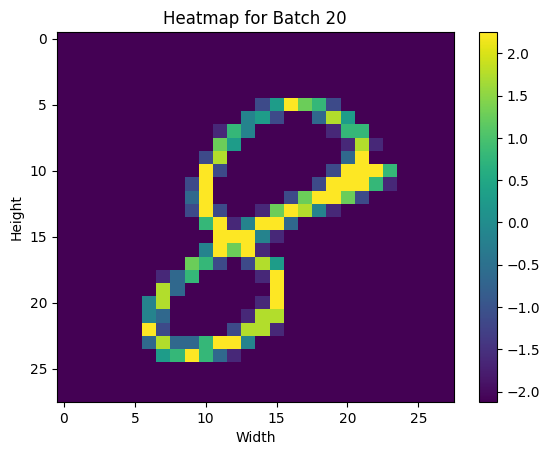

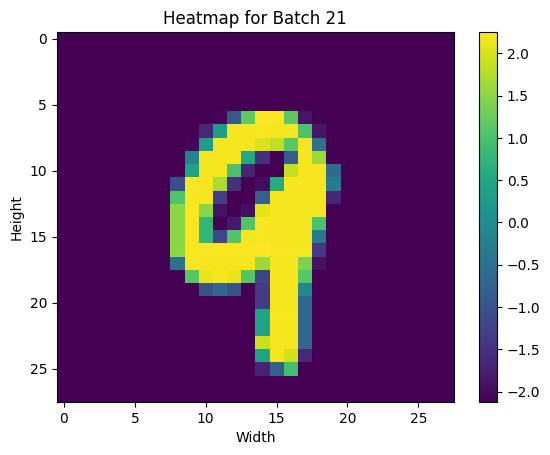

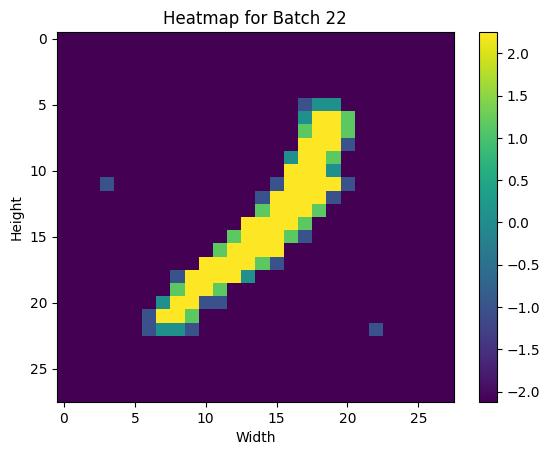

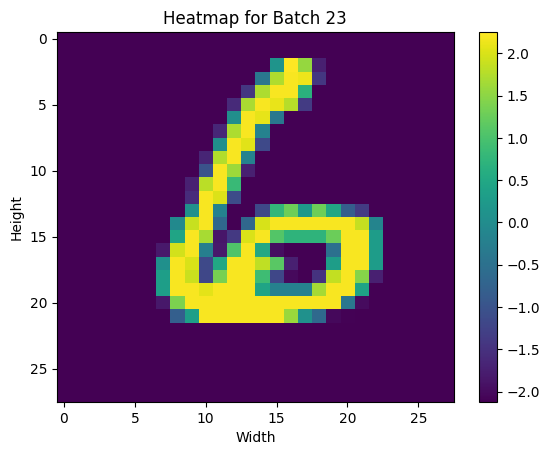

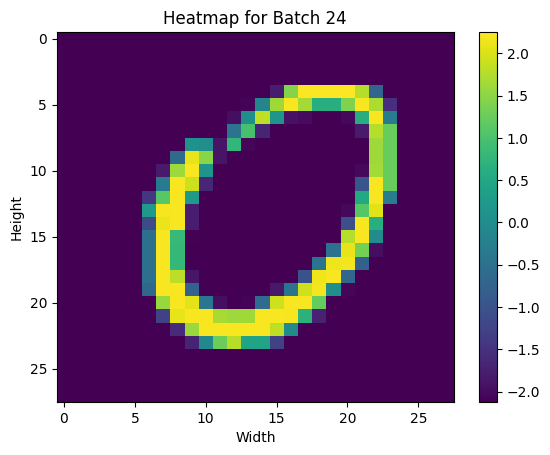

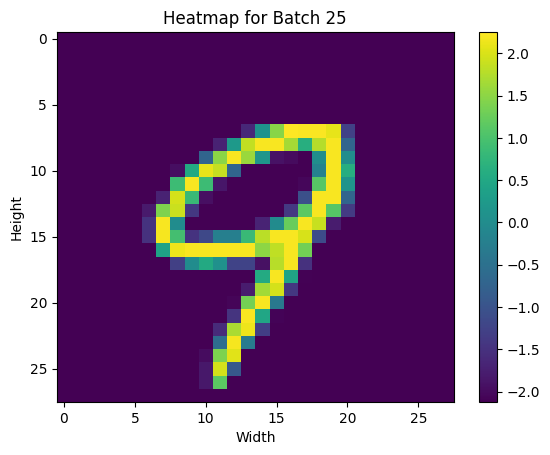

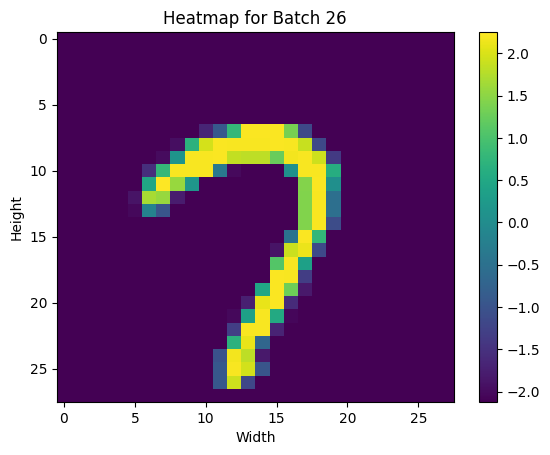

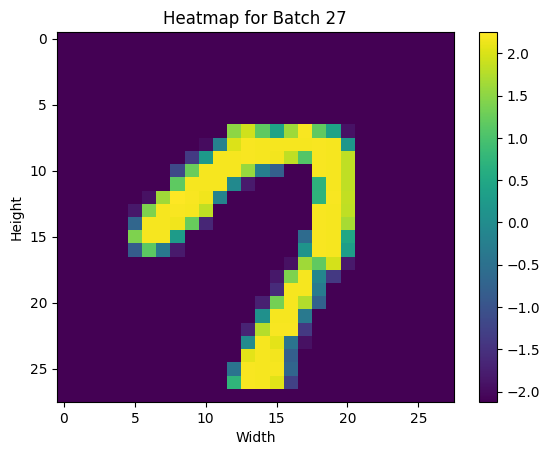

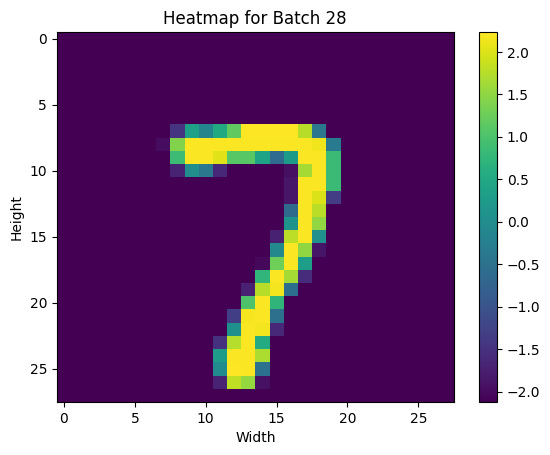

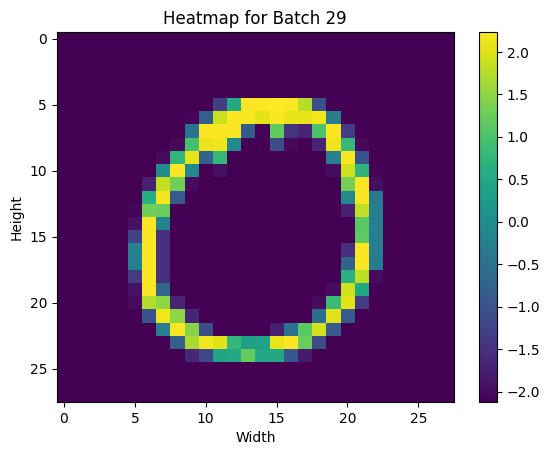

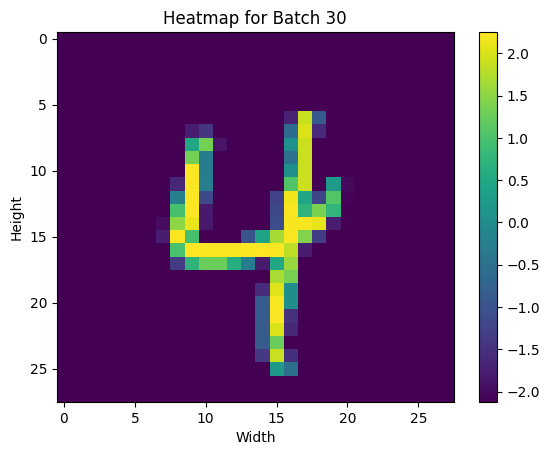

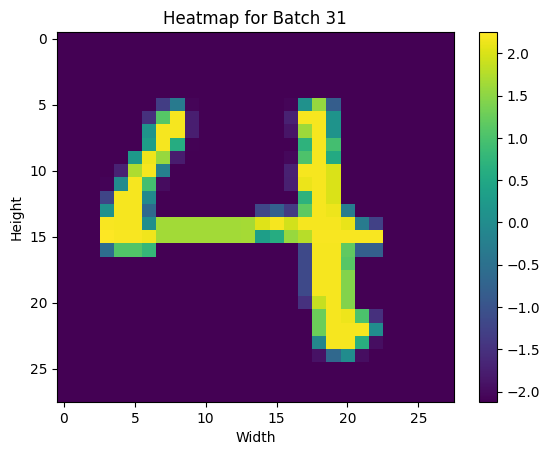

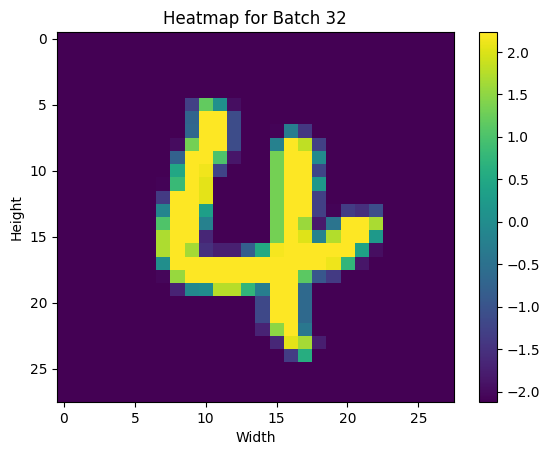

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the numpy array
file_path = "FC_2Layer_INT8_input.npy"  # Replace with your file path
matrix = np.load(file_path)

# Ensure the matrix has the expected shape
assert matrix.shape == (32, 28, 28, 1), f"Unexpected shape: {matrix.shape}"

# Remove the last dimension to work with 2D matrices
matrix = matrix.squeeze(axis=-1)

# Create heatmaps for each batch
for i in range(matrix.shape[0]):
    plt.figure()
    plt.imshow(matrix[i], cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(f"Heatmap for Batch {i+1}")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.show()

# Check full onnx


In [ ]:
! pip install onnx onnxruntime qonnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.3/278.3 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


In [ ]:
!pip install finn qonnx

In [ ]:
%%bash
git clone https://github.com/Xilinx/finn.git
cd finn
pip install -r requirements.txt
pip install -e .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.8/195.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of virtualenv to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of virtualenv to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press 

Cloning into 'finn'...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.24.1 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.24.1 which is incompatible.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.12.2 which is incompatible.
pymc 5.19.1 requires numpy>=1.25.0, but you have numpy 1.24.1 which is incompatible.
scikit-image 0.25.0 requires scipy>=1.11.2, but you have scipy 1.10.1 which is incompatible.


In [ ]:
!python -c "import finn; print('FINN installed successfully')"


FINN installed successfully


In [ ]:
!grep -r "def execute_onnx" .


./finn/src/finn/core/onnx_exec.py:def execute_onnx(model, input_dict, return_full_exec_context=False, start_node=None, end_node=None):
./finn/src/finn/core/onnx_exec.py:def execute_onnx_and_make_model(model, input_dict):


In [ ]:
import finn


In [ ]:
dir(finn)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [ ]:
import numpy as np

# Paths to files
input_path = "/content/FC_2Layer_INT8_input.npy"
output_path = "/content/FC_2Layer_INT8_output.npy"
weight1_path = "/content/Quant_0_param0.npy"
bias1_path = "/content/Gemm_0_param0.npy"
weight2_path = "/content/Quant_1_param0.npy"
bias2_path = "/content/Gemm_1_param0.npy"
import numpy as np

# Load inputs, weights, biases, and reference outputs
input_data = np.load(input_path)[0]
output_original = np.load(output_path)[0]
weight1 = np.load(weight1_path)
bias1 = np.load(bias1_path)
weight2 = np.load(weight2_path)
bias2 = np.load(bias2_path)

# Quantization Parameters
scale_input = 0.01649258
zero_point_input = 0

scale_weight1 = 0.00173154
zero_point_weight1 = 0

scale_output1 = 0.015937
zero_point_output1 = 0

scale_weight2 = 0.00304457
zero_point_weight2 = 0

scale_output2 = 0.039213538
zero_point_output2 = 0

# Quantization Functions
def quantize(value, scale, zero_point):
    """Quantizes a floating-point value into an integer."""
    return np.round(value / scale).astype(np.int32) + zero_point

def dequantize(value, scale, zero_point):
    """Dequantizes an integer value back to floating-point."""
    return scale * (value - zero_point)

def adjust_bias(bias, input_scale, weight_scale):
    """Adjust bias for quantization."""
    return np.round(bias / (input_scale * weight_scale)).astype(np.int32)

# Quantize weights and biases
weight1_quant = quantize(weight1, scale_weight1, zero_point_weight1)
bias1_quant = adjust_bias(bias1, scale_input, scale_weight1)

weight2_quant = quantize(weight2, scale_weight2, zero_point_weight2)
bias2_quant = adjust_bias(bias2, scale_output1, scale_weight2)

# Forward Pass Functions
def dense_quantized(x, weight, bias, scale_input, scale_weight, scale_output, zero_point_output):
    """Simulates a quantized dense (GEMM) layer."""
    M = scale_input * scale_weight / scale_output  # Overall scaling factor
    # Quantized GEMM
    y_quant = np.dot(x, weight.T) + bias
    y = np.round(M * y_quant).astype(np.int32) + zero_point_output
    return y

def relu_quantized(x):
    """Simulates a quantized ReLU activation."""
    return np.maximum(x, 0)

# Prepare input
input_flat = input_data.flatten()  # Flatten the input
input_quant = quantize(input_flat, scale_input, zero_point_input)

# First Dense Layer
output1_quant = dense_quantized(input_quant, weight1_quant, bias1_quant,
                                scale_input, scale_weight1, scale_output1, zero_point_output1)
output1_quant = relu_quantized(output1_quant)

# Second Dense Layer
output2_quant = dense_quantized(output1_quant, weight2_quant, bias2_quant,
                                scale_output1, scale_weight2, scale_output2, zero_point_output2)

# Dequantize Final Output
output2 = dequantize(output2_quant, scale_output2, zero_point_output2)

# Compare Final Output
print("Final Output:", output2)
print("Original Output:", output_original)


FileNotFoundError: [Errno 2] No such file or directory: '/content/Quant_0_param0.npy'

In [ ]:
np.load(output_path).argmax(axis=1).astype(int)

array([2, 6, 8, 7, 5, 4, 7, 5, 2, 7, 3, 9, 3, 0, 9, 6, 3, 0, 1, 8, 9, 1,
       6, 0, 9, 7, 7, 7, 0, 4, 4, 4])

In [ ]:
import numpy as np

# Load inputs, weights, biases, and reference outputs
input_data = np.load(input_path)[0]
output_original = np.load(output_path)[0]
weight1 = np.load(weight1_path)
bias1 = np.load(bias1_path)
weight2 = np.load(weight2_path)
bias2 = np.load(bias2_path)

# Quantization Parameters
scale_input = 0.01649258
zero_point_input = 0

scale_weight1 = 0.00173154
zero_point_weight1 = 0

scale_output1 = 0.015937
zero_point_output1 = 0

scale_weight2 = 0.00304457
zero_point_weight2 = 0

scale_output2 = 0.039213538
zero_point_output2 = 0

# Mathematical functions to replace operations
def quantize(value, scale, zero_point):
    """Quantizes a value mathematically."""
    return np.round(value / scale) + zero_point

def dequantize(value, scale, zero_point):
    """Dequantizes a value mathematically."""
    return scale * (value - zero_point)

def adjust_bias(bias, input_scale, weight_scale):
    """Adjusts bias mathematically."""
    return np.round(bias / (input_scale * weight_scale))

def dense_layer(input_data, weight, bias, input_scale, weight_scale, output_scale, zero_point_output):
    """Dense layer implementation in mathematical terms."""
    # Overall scaling factor
    M = input_scale * weight_scale / output_scale
    # Matrix multiplication and bias addition
    y = np.dot(input_data, weight.T) + bias
    # Apply scaling factor and zero-point
    y_scaled = np.round(M * y) + zero_point_output
    return y_scaled

def relu_activation(x):
    """Mathematical ReLU implementation."""
    return np.maximum(x, 0)

# Process the input through mathematical functions
# Flatten the input and quantize
input_flat = input_data.flatten()
input_quant = quantize(input_flat, scale_input, zero_point_input)

# Quantize weights and adjust biases for each layer
weight1_quant = quantize(weight1, scale_weight1, zero_point_weight1)
bias1_quant = adjust_bias(bias1, scale_input, scale_weight1)

weight2_quant = quantize(weight2, scale_weight2, zero_point_weight2)
bias2_quant = adjust_bias(bias2, scale_output1, scale_weight2)

# First layer mathematical operation
output1_quant = dense_layer(input_quant, weight1_quant, bias1_quant,
                            scale_input, scale_weight1, scale_output1, zero_point_output1)



output1_quant = relu_activation(output1_quant)

# Second layer mathematical operation
output2_quant = dense_layer(output1_quant, weight2_quant, bias2_quant,
                            scale_output1, scale_weight2, scale_output2, zero_point_output2)

# Dequantize the output mathematically
output2 = dequantize(output2_quant, scale_output2, zero_point_output2)

# Print final outputs
print("Final Output:", output2)
print("Original Output:", output_original)
print(output1_quant)


NameError: name 'input_path' is not defined

In [ ]:
weight1[0] / scale_weight1

array([  2.963458  ,  -1.481729  ,  -0.7408645 ,  -5.1860514 ,
         2.2225935 ,  -5.926916  ,  -6.297348  ,   7.038213  ,
        -5.5564837 ,  -6.297348  ,  -7.408645  ,  -3.7043226 ,
        12.224264  ,  17.039885  ,   5.5564837 ,   1.8521613 ,
         0.37043226,  -4.815619  ,   3.3338904 ,   4.445187  ,
        -7.038213  ,   7.779077  ,   3.3338904 ,   6.667781  ,
        -3.3338904 ,  -4.815619  ,   2.5930257 ,   7.408645  ,
         1.8521613 ,   3.7043226 ,   7.779077  ,   1.8521613 ,
        -1.8521613 ,  -1.8521613 ,   7.779077  ,   9.260806  ,
         4.445187  ,  15.187721  ,  10.372103  ,   6.297348  ,
         3.7043226 ,  10.372103  ,   2.2225935 ,   6.667781  ,
         8.519942  ,   6.667781  ,   6.297348  ,  10.742536  ,
         2.963458  ,  11.4834    ,   0.37043226,  -3.7043226 ,
         6.297348  ,   2.2225935 ,  -0.37043226,   7.408645  ,
        -3.7043226 ,   5.5564837 ,  -6.297348  ,   1.8521613 ,
       -10.742536  ,  -3.3338904 ,   5.5564837 ,  21.48

In [ ]:
(input_data * 61).max()

137.18341

In [ ]:
bias1

array([-0.4047681 , -5.1757975 ,  0.1347596 , -3.7044234 , -1.2223685 ,
       -3.7695863 , -1.6609843 ,  1.1663957 ,  0.4639687 ,  2.7102532 ,
       -1.9960675 ,  1.200359  ,  0.7343266 , -2.514952  , -1.2265993 ,
        3.421804  , -2.1796381 , -0.5490261 , -0.5419694 ,  3.248905  ,
        1.5988623 , -0.8842349 ,  0.13423964,  1.006505  , -0.2296889 ,
       -8.220235  , -6.2982345 ,  1.6072723 , -3.8400083 , -1.260251  ,
       -3.3047764 ,  3.6006145 , -2.134012  ,  2.9032845 ,  1.7695949 ,
        0.9231392 ,  5.050285  ,  2.7862177 , -6.1621084 , -3.8043602 ,
        0.6164434 , -4.667222  ,  2.8429914 ,  1.4858178 , -4.4234424 ,
       -3.4635682 , -3.2717197 , -2.6365013 ,  6.9050674 , -1.7874511 ,
        1.8935813 , -2.3200967 ,  3.3847795 , -3.062606  ,  2.256192  ,
        1.0780118 , -2.4710608 , -1.6162909 ,  2.9872568 ,  4.254279  ,
        8.137833  , -2.8622787 , -1.754911  ,  2.0505512 ,  1.083961  ,
       -3.7146213 ,  9.339325  , -0.6757298 , -6.1198187 , -1.90

In [ ]:
input_quant

array([-128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128.,

In [ ]:
import numpy as np

# Paths to files
input_path = "FC_2Layer_INT8_input.npy"
output_path = "FC_2Layer_INT8_output.npy"
weight1_path = "MatMul_0_param0.npy"
bias1_path = "Add_0_param0.npy"
weight2_path = "MatMul_1_param0.npy"
bias2_path = "Add_1_param0.npy"

# Quantization Parameters
scale_input = 0.01649007  # Scale for input
zero_point_input = 0      # Zero-point for input

scale_weight1 = 0.01593484  # Scale for first layer weights
zero_point_weight1 = 0      # Zero-point for first layer weights

scale_output1 = 0.03920404  # Scale for first layer output
zero_point_output1 = 0      # Zero-point for first layer output

scale_weight2 = 0.01593484  # Scale for second layer weights
zero_point_weight2 = 0      # Zero-point for second layer weights

scale_output2 = 0.03920404  # Scale for second layer output
zero_point_output2 = 0      # Zero-point for second layer output

# Load input, weights, and biases
input_data = np.load(input_path)[0]  # Load the input data
output_original = np.load(output_path)[0]  # Load the expected output
weight1 = np.load(weight1_path)  # First layer weights
bias1 = np.load(bias1_path)  # First layer biases
weight2 = np.load(weight2_path)  # Second layer weights
bias2 = np.load(bias2_path)  # Second layer biases

# Quantization Functions
def quantize(value, scale, zero_point):
    """Quantizes a floating-point value into an integer."""
    return np.round(value / scale).astype(np.int32) + zero_point

def dequantize(value, scale, zero_point):
    """Dequantizes an integer value back to floating-point."""
    return scale * (value - zero_point)

def adjust_bias(bias, input_scale, weight_scale):
    """Adjusts the bias for quantization."""
    return np.round(bias / (input_scale * weight_scale)).astype(np.int32)

# Quantize weights and biases
weight1_quant = quantize(weight1, scale_weight1, zero_point_weight1)
bias1_quant = adjust_bias(bias1, scale_input, scale_weight1)

weight2_quant = quantize(weight2, scale_weight2, zero_point_weight2)
bias2_quant = adjust_bias(bias2, scale_output1, scale_weight2)

# Forward Pass
def dense_quantized(x, weight, bias, scale_input, scale_weight, scale_output):
    """Simulates a quantized dense (GEMM) layer."""
    M = scale_input * scale_weight / scale_output  # Overall scaling factor
    y_quant = np.dot(x, weight) + bias  # Matrix multiplication and bias addition
    y = np.round(M * y_quant).astype(np.int32)  # Apply scale factor
    return y

def relu_quantized(x):
    """Simulates a quantized ReLU activation."""
    return np.maximum(x, 0)

# Prepare input
input_flat = input_data.flatten()  # Flatten the input
input_quant = quantize(input_flat, scale_input, zero_point_input)

# First Dense Layer
output1_quant = dense_quantized(input_quant, weight1_quant, bias1_quant,
                                scale_input, scale_weight1, scale_output1)
output1_quant = relu_quantized(output1_quant)

# Second Dense Layer
output2_quant = dense_quantized(output1_quant, weight2_quant, bias2_quant,
                                scale_output1, scale_weight2, scale_output2)

# Dequantize Final Output
output2 = dequantize(output2_quant, scale_output2, zero_point_output2)

# Print Results
print("Quantized Model Final Output:", output2)
print("Original Output:", output_original)


Quantized Model Final Output: [-164550.80345968  141030.14364148 -676365.77910204 -562858.36129408
 -492943.09168332 -171091.25265692 -883473.46967464  399153.81624184
   12297.87610356 -257579.87336152]
Original Output: [-6.6804895   5.927752   -2.1162996  -1.665479   -2.6973078  -4.7859755
 -4.932472   -1.4184679  -0.85031223 -2.1959383 ]


In [ ]:
output1_quant.shape

NameError: name 'output1_quant' is not defined

In [ ]:
output1_quant

array([[ 27001,  92216,      0,  57389,  21414,  17312,  18574,      0,
             0,      0,  46323,      0,      0,  33609,      0,      0,
         53840,  29091,   9701,      0,      0,  37892,  23116,      0,
         36160, 133941,  94606,      0,  48937,  17129,  45774,      0,
         29125,      0,      0,      0,      0,      0, 106540,  19211,
             0,  89424,      0,      0,  74504,  46613,  35602,  34126,
             0,  26374,      0,  42746,      0,  39266,      0,      0,
         29175,  25805,      0,      0,      0,  81429,    679,      0,
             0,  47022,      0,  11121, 115214,  11221,  43572,      0,
         51673,  51081,  57257,  35793,      0,  37083,      0,  49478,
             0,      0,      0,      0,  31110,      0,      0,  89149,
         79823,      0,  34694,      0,      0,      0,  68241,  34220,
         33563,      0,  41017,      0,  40836,  10235,      0, 113724,
         85432,   6488,  38671,      0,      0,      0,      0, 

In [ ]:
input_quant

array([-128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128., -128., -128., -128., -128., -128., -128., -128.,
       -128., -128.,

In [ ]:
zero_point_output1

0

In [ ]:
weight1_quant

array([[ -1,  11, -10, ..., -11,  -2,  13],
       [ 16,  12,   2, ..., -12,  15,  -3],
       [ 13,  11,   4, ...,  17,   1,  -4],
       ...,
       [  9,   2, -16, ...,  -2,  -4,  14],
       [-13,  19, -10, ...,   6,   1,   1],
       [ 10,   4,  -8, ...,  15,   6,  -9]], dtype=int32)

In [ ]:
import numpy as np

class NeuralNetworkLayer:
    def __init__(self, input_data, weights=None, biases=None):
        """
        Initialize the layer with input data, weights, and optional biases.
        """
        self.input_data = input_data
        self.weights = weights
        self.biases = biases

    def perform_matrix_multiplication(self):
        """
        Perform matrix multiplication between input data and weights.
        """
        if self.weights is None:
            raise ValueError("Weights must be set for matrix multiplication.")
        return np.dot(self.input_data, self.weights)

    @staticmethod
    def apply_multiplication(data, scalar):
        """
        Apply scalar multiplication to the data.
        """
        return data * scalar

    @staticmethod
    def perform_addition(data, biases):
        """
        Add biases to the data element-wise.
        """
        if biases is None:
            raise ValueError("Biases must be provided for addition.")
        return data + biases

    @staticmethod
    def apply_relu(data):
        """
        Apply ReLU activation function to the data.
        """
        return np.maximum(0, data)

    @staticmethod
    def apply_clip(data, min_value, max_value):
        """
        Clip the data to a specified range.
        """
        return np.clip(data, min_value, max_value)

def load_and_prepare_input(input_path, scaler):
    """
    Load input data, ensure it's reshaped to (28, 28, 1), and flatten it.
    """
    input_data = scaler * np.load(input_path)  # Assuming input shape is correct
    # if input_data.shape != (28, 28, 1):  # Ensure correct input shape
    #     raise ValueError(f"Expected input shape (28, 28, 1), but got {input_data.shape}")
    return input_data.astype(np.int32)  # Flatten to (784,)

def neural_network_pipeline():
    """
    Execute the neural network pipeline using integer operations.
    """

    # Load weights and biases
    scalar_mul1 = 61  # First layer scalar multiplier
    weights_matmul0 = np.load("float_model/MatMul_0_param0.npy").astype(np.float32)  # (784, 128)
    biases_add0 = np.load("float_model/Add_0_param0.npy").astype(np.float32)  # (128,)
    weights_matmul1 = np.load("float_model/MatMul_1_param0.npy").astype(np.float32)  # (128, 10)
    scalar_mul2 = 0.000030517578125
    scalar_mul3 = 26
    scalar_mul4 = 0.0001220703125


    # Load and prepare input data
    input_arr = load_and_prepare_input("FC_2Layer_INT8_input.npy", scalar_mul1)  # Input as integers
    output_orig = np.load("FC_2Layer_INT8_output.npy").astype(np.float32)  # (10,)

    for batch in range(input_arr.shape[0]):
      input_data = input_arr[batch].flatten()

      # biases_add1 = np.load("float_model/Add_1_param0.npy").astype(np.float32)  # (10,)

      # Layer 1: Flatten -> Clip -> MatMul -> Add
      input_clipped = NeuralNetworkLayer.apply_clip(input_data, -128, 127)  # Clip input to [-128, 127]

      layer1 = NeuralNetworkLayer(input_data=input_clipped, weights=weights_matmul0, biases=biases_add0)
      matmul0_out = layer1.perform_matrix_multiplication()
      matmul0_out = matmul0_out * scalar_mul2
      matmul0_out = NeuralNetworkLayer.perform_addition(matmul0_out, biases_add0)



      # Layer 2: ReLU -> Multiply -> Clip
      relu_out = NeuralNetworkLayer.apply_relu(matmul0_out)

      relu_out_scaled = NeuralNetworkLayer.apply_multiplication(relu_out, scalar_mul3)

      layer2 = NeuralNetworkLayer(input_data=relu_out_scaled, weights=weights_matmul1, biases=None)
      matmul1_out = layer2.perform_matrix_multiplication()
      final_output = NeuralNetworkLayer.apply_multiplication(matmul1_out, scalar_mul4)


      # Display the result
      print("Final Output:", final_output.astype(np.int32).argmax())

      print("Original Output:", output_orig[batch].astype(np.int32).argmax())

if __name__ == "__main__":
    neural_network_pipeline()


Final Output: 2
Original Output: 2
Final Output: 6
Original Output: 6
Final Output: 8
Original Output: 8
Final Output: 7
Original Output: 7
Final Output: 5
Original Output: 5
Final Output: 4
Original Output: 4
Final Output: 7
Original Output: 7
Final Output: 5
Original Output: 5
Final Output: 2
Original Output: 2
Final Output: 7
Original Output: 7
Final Output: 3
Original Output: 3
Final Output: 9
Original Output: 9
Final Output: 3
Original Output: 3
Final Output: 0
Original Output: 0
Final Output: 9
Original Output: 9
Final Output: 6
Original Output: 6
Final Output: 2
Original Output: 2
Final Output: 0
Original Output: 0
Final Output: 1
Original Output: 1
Final Output: 8
Original Output: 8
Final Output: 9
Original Output: 9
Final Output: 1
Original Output: 1
Final Output: 6
Original Output: 6
Final Output: 0
Original Output: 0
Final Output: 9
Original Output: 9
Final Output: 7
Original Output: 7
Final Output: 7
Original Output: 7
Final Output: 7
Original Output: 7
Final Output: 0
Orig

In [ ]:
inp.shape, wgt.shape

((784,), (784, 128))

In [ ]:
np.dot(inp, wgt[:, 0])

-189982.0

In [ ]:
import numpy as np

In [ ]:
output_original = np.load("FC_2Layer_INT4_output.npy")

In [ ]:
output_original.argmax(axis=1)

array([1, 4, 1, 4, 0, 8, 0, 3, 9, 9, 5, 8, 4, 6, 6, 8, 0, 0, 3, 1, 1, 7,
       7, 8, 9, 7, 0, 4, 7, 6, 1, 2])